In [2]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [3]:
include(srcdir("TissueModel_ND.jl"))

include(srcdir("Evolution.jl"))
include(srcdir("FitnessFunctions.jl"))

include(srcdir("NetworkTopologies.jl"))
include(srcdir("Utility.jl"))

using Plots
using Random
using Parameters
using Printf
using DataFrames
using StatsPlots
using Distances

using Base.Threads
using Base.Threads: @spawn

example_networks = load(datadir("exp_pro/80-40-80_networks/examples.jld"))

Dict{String, Any} with 6 entries:
  "bistable"     => NaN
  "feed_forward" => [0.0 0.0 0.0 0.19495; 0.173532 0.0 0.0 0.0; 3.02262 -5.5322…
  "classical"    => [0.0 0.0 0.0 0.114353; -0.560775 0.359711 0.0 0.0; -0.07258…
  "frozen_osc"   => NaN
  "mutual_inh"   => [0.0 0.0 0.0 0.2454; 0.455819 0.0 -2.23319 0.0; 0.446651 -2…
  "overlap_dom"  => [0.0 0.0 -0.00379469 0.228214; 0.653415 0.0 0.0 0.0; -0.424…

In [180]:
start_network = example_networks["feed_forward"]

3×4 Matrix{Float64}:
 0.0        0.0      0.0       0.19495
 0.173532   0.0      0.0       0.0
 3.02262   -5.53221  0.170243  0.0

In [181]:
grn_parameters = DefaultGRNParameters()

p = (start_network,grn_parameters.degradation)
    
grn = ODEProblem(gene_regulation_1d!,grn_parameters.g0,(0,Inf),p)

development = DefaultGRNSolver()

founder = Individual(grn,development);

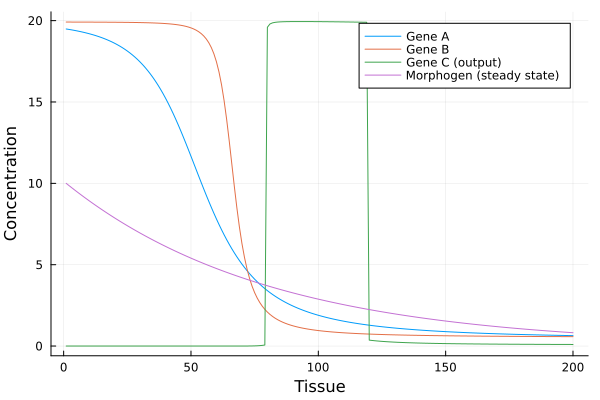

In [182]:
plot_SS(founder.phenotype.u[end])

In [183]:
function increment_weight(choice,val,w)
    new_w = copy(w)
    new_w[choice...] += val
    return new_w
end

increment_weight (generic function with 1 method)

In [184]:
n_stripe = 1

stripe_threshold = 5.

min_width = 5.

output_gene = 3

target = [(40.,20.)]

fitness_function = s -> fitness_evaluation(s,x->f_sim_cw(x,stripe_threshold,n_stripe,target,min_width),output_gene)

#99 (generic function with 1 method)

In [185]:
function create_mutant_get_fitness(founder,development,fitness_function,entry,step)

    mutant = create_mutant(founder,x->increment_weight(entry,step,x),development)

    mutant_fitness,mutant_pheno_class = fitness_function(mutant.phenotype)

    if mutant_fitness[1] == 0.
        actual_fitness = mutant_fitness[2]
    else
        actual_fitness = Inf
    end

    return actual_fitness

end

create_mutant_get_fitness (generic function with 1 method)

In [186]:
using Base.Threads
using Base.Threads: @spawn

In [187]:
current_fitness,class = fitness_function(founder.phenotype);

In [188]:
current_fitness[2]

3481.0

In [189]:
entry = (3,2)

N_sample = 1000

sample_steps = range(-1,1,length = N_sample)

all_fitnesses = zeros(N_sample)

@sync for i in 1:length(sample_steps)
    @spawn all_fitnesses[i] = create_mutant_get_fitness(founder,development,fitness_function,entry,sample_steps[i])
end

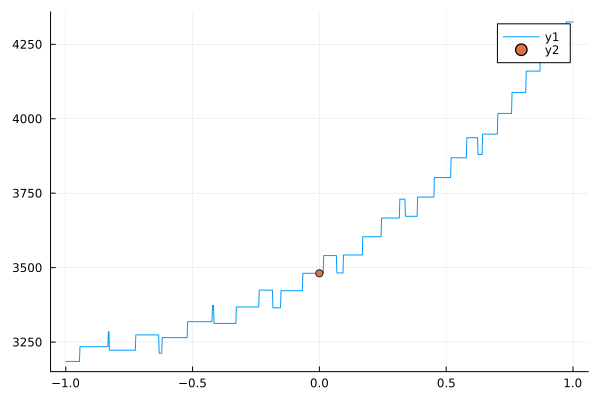

In [190]:
p = plot(sample_steps,all_fitnesses)
scatter!(p,(0.,current_fitness[2]))

In [191]:
N_sample = 1000

sample_steps = range(-3,3,length = N_sample)

results = Dict()

for i in 1:size(start_network,1)
    for j in 1:size(start_network,2)

        all_fitnesses = zeros(N_sample)

        @sync for s in 1:length(sample_steps)
            @spawn all_fitnesses[s] = create_mutant_get_fitness(founder,development,fitness_function,(i,j),sample_steps[s])
        end

        results[(i,j)] = all_fitnesses
    end
end    

In [192]:
function improvement_intervals(fitnesses,cf)

    less_than = fitnesses .< cf

    index_less = findall(x-> x,less_than)

    if length(index_less) > 2
    
        start = index_less[1]
        
        mass = 0.
        
        for i in 1:length(index_less)-1
        
            if index_less[i] + 1 < index_less[i+1] 
        
                mass += cdf(noise_dist,sample_steps[index_less[i]]) - cdf(noise_dist,sample_steps[start])
        
                start = index_less[i+1] 
        
            # elseif i+1 == length(index_less)-1
        
            #     mass += cdf(noise_dist,sample_steps[index_less[i+1]]) - cdf(noise_dist,sample_steps[start])
            # end
            end
        
        end
        
        mass += cdf(noise_dist,sample_steps[index_less[end]]) - cdf(noise_dist,sample_steps[start])

    else
        mass = 0.
    end

    return mass
end

improvement_intervals (generic function with 1 method)

In [193]:
plot_list = []

noise_dist = Normal(0.,1.)

sum_mass = 0.

for (entry,data) in results

    mass = improvement_intervals(data,current_fitness[2])

    sum_mass += mass

    p = plot(sample_steps,data, title = string(entry) * " - " * string(round(mass,digits =3)))
    plot!(twinx(),noise_dist,color = :red)
    scatter!(p,(0.,current_fitness[2]))
    hline!(p,[current_fitness[2]])

    push!(plot_list,p)

end

average_mass = sum_mass / 12

0.13815718644395536

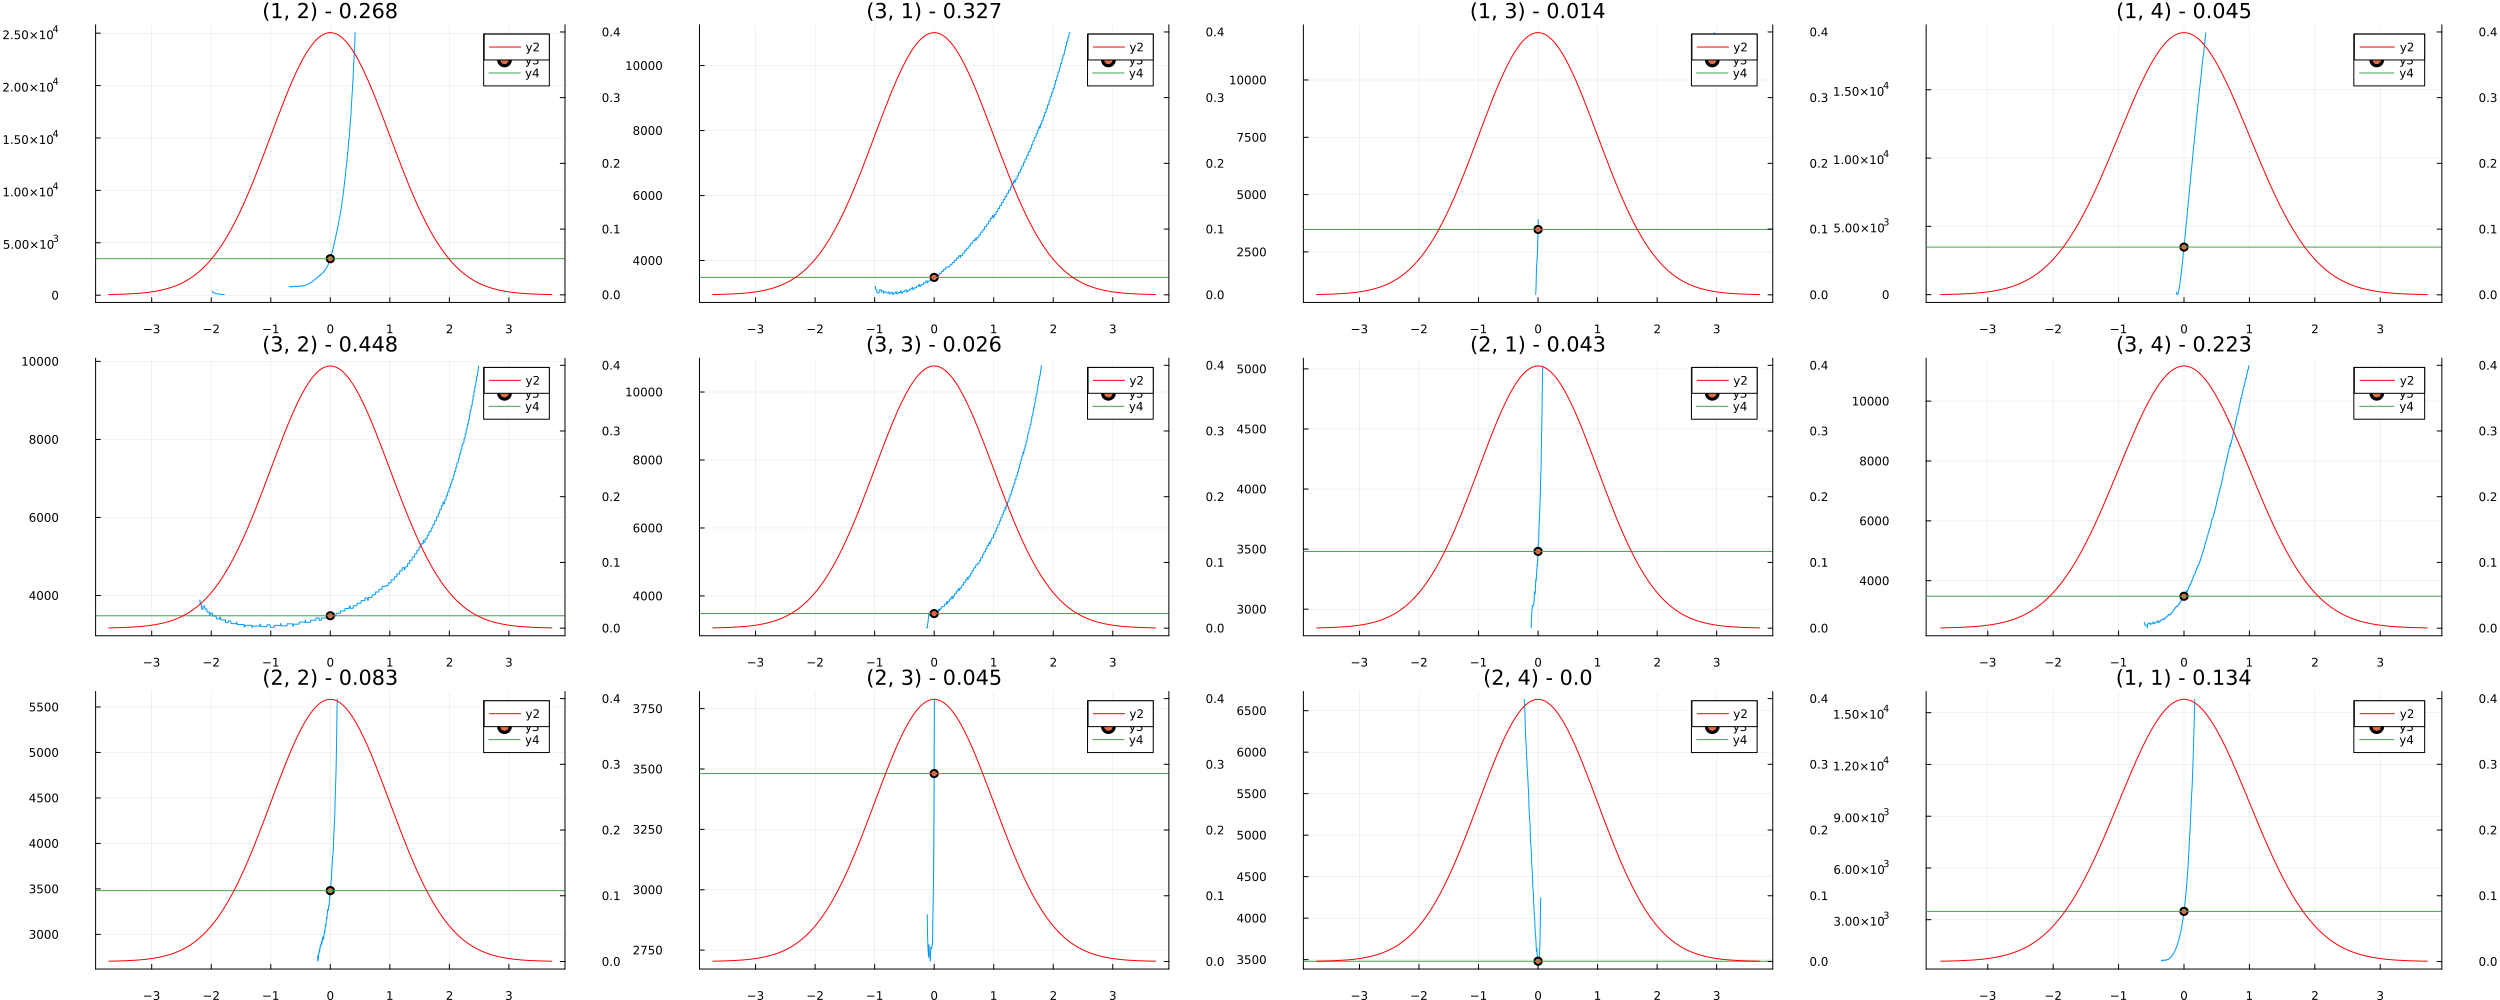

In [194]:
plot(plot_list..., size = (2500,1000))

In [81]:
# x -> x+ x*n stops zero edge 